# Notebook 3: Agentic RAG Pipeline

**Objectives:**
- Build 2-agent system using LangGraph (Retrieval Agent + Response Agent)
- Create FastAPI backend with `/recommend` endpoint
- Implement LangSmith logging for observability
- Test end-to-end functionality

**✅✅✅ Simplified Architecture:**
- **Agent 1 (Retrieval):** Extracts filters → Searches Qdrant → Returns events
- **Agent 2 (Response):** Formats events → Returns natural language response
- **Linear flow:** No complex conditional logic needed

---


## Setup & Imports


In [1]:
# Install required packages if needed
# !pip install langchain langgraph langsmith openai fastapi uvicorn pydantic


In [2]:
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Any, TypedDict
from dotenv import load_dotenv

# LangChain imports
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END

# Add backend to path for imports
sys.path.append(str(Path("..").resolve()))
from backend.vector_store import VectorStore

# Load environment variables
load_dotenv()

# Configure LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "nyc-event-recommender"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

print("✅ Imports successful!")
print(f"OpenAI API Key: {'✓' if os.getenv('OPENAI_API_KEY') else '✗'}")
print(f"LangSmith API Key: {'✓' if os.getenv('LANGCHAIN_API_KEY') else '✗'}")
print(f"LangSmith Tracing: {'Enabled' if os.getenv('LANGCHAIN_TRACING_V2') == 'true' else 'Disabled'}")


✅ Imports successful!
OpenAI API Key: ✓
LangSmith API Key: ✓
LangSmith Tracing: Enabled


## 1. Agent Architecture Design

**✅✅✅ 2-Agent System Overview:**

```
┌─────────────┐
│ User Query  │
└──────┬──────┘
       │
       ▼
┌─────────────────────────────┐
│  RETRIEVAL AGENT            │
│  - Extract filters from     │
│    query (baby_friendly,    │
│    price, category, etc.)   │
│  - Embed query              │
│  - Search Qdrant            │
│  - Return top-K events      │
└──────┬──────────────────────┘
       │
       ▼
┌─────────────────────────────┐
│  RESPONSE AGENT             │
│  - Format events naturally  │
│  - Highlight key details    │
│  - Return markdown response │
└──────┬──────────────────────┘
       │
       ▼
┌─────────────┐
│   Output    │
└─────────────┘
```

**Why 2 Agents?**
- **Separation of concerns:** Retrieval logic vs. formatting logic
- **Easier to debug:** Can test each agent independently
- **Faster:** No complex routing or conditional logic
- **Sufficient:** Semantic search handles nuance; no need for query planning agent

**Agentic Reasoning:**
- **Retrieval Agent:** Uses LLM to intelligently extract filters from natural language
- **Response Agent:** Uses LLM to format output conversationally

---


## 2. Define State Schema


In [3]:
class AgentState(TypedDict):
    """State passed between agents in the pipeline."""
    query: str                          # Original user query
    filters: Dict[str, Any]             # Extracted metadata filters
    retrieved_events: List[Dict]        # Events from Qdrant
    response: str                       # Final formatted response
    
print("✅ State schema defined!")


✅ State schema defined!


## 3. Agent 1: Retrieval Agent

**Responsibilities:**
1. Extract metadata filters from query (baby_friendly, price, etc.)
2. Embed the query
3. Search Qdrant with semantic search + filters
4. Return top-K relevant events


In [5]:
# Initialize components
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
vector_store = VectorStore(path="../local_qdrant")

def retrieval_agent(state: AgentState) -> AgentState:
    """
    Agent 1: Extract filters and retrieve relevant events.
    """
    query = state["query"]
    
    # Step 1: Extract filters using LLM
    filter_prompt = f"""Given this user query about NYC events, extract any explicit filters.

Query: "{query}"

Return JSON with these optional filters:
- baby_friendly: true/false (if query mentions babies, infants, toddlers, strollers, kids, family-friendly)
- price: "free" (only if query explicitly mentions free)

If a filter is not mentioned, omit it from the JSON.

Examples:
- "baby-friendly museum" → {{"baby_friendly": true}}
- "free outdoor event" → {{"price": "free"}}
- "romantic date night" → {{}}
- "stroller-accessible park" → {{"baby_friendly": true}}

Return ONLY valid JSON, no explanations."""

    try:
        filter_response = llm.invoke([
            SystemMessage(content="You extract metadata filters from user queries. Always return valid JSON."),
            HumanMessage(content=filter_prompt)
        ])
        
        filters = json.loads(filter_response.content)
        print(f"🔍 Extracted filters: {filters}")
    except Exception as e:
        print(f"⚠️  Filter extraction failed: {e}. Using no filters.")
        filters = {}
    
    # Step 2: Search vector store
    search_results = vector_store.search_events(
        query=query,
        top_k=10,
        filters=filters if filters else None
    )
    
    print(f"✅ Retrieved {len(search_results)} events")
    
    # Update state
    state["filters"] = filters
    state["retrieved_events"] = search_results
    
    return state

print("✅ Retrieval Agent defined!")


✅ Retrieval Agent defined!


## 4. Agent 2: Response Agent

**Responsibilities:**
1. Take retrieved events
2. Format them naturally using GPT-4
3. Highlight key details (title, description, baby-friendliness, URL)
4. Return markdown-formatted response


In [6]:
def response_agent(state: AgentState) -> AgentState:
    """
    Agent 2: Format retrieved events into natural language response.
    """
    query = state["query"]
    events = state["retrieved_events"]
    
    if not events:
        state["response"] = "I couldn't find any events matching your criteria. Try broadening your search!"
        return state
    
    # Prepare event context for LLM
    event_context = ""
    for i, result in enumerate(events[:5], 1):  # Top 5 events
        event = result["event"]
        score = result["score"]
        event_context += f"""
Event {i}:
- Title: {event['title']}
- Description: {event['description'][:200]}...
- Baby-Friendly: {'Yes' if event['baby_friendly'] else 'No'}
- URL: {event['url']}
- Relevance Score: {score:.2f}

"""
    
    # Generate response
    response_prompt = f"""You are a helpful NYC event recommender assistant.

User Query: "{query}"

Here are the top events I found:
{event_context}

Task: Write a friendly, conversational response recommending these events. Include:
1. A brief intro acknowledging their query
2. Top 3-5 events with titles, brief descriptions, and key details
3. Mention if events are baby-friendly when relevant
4. Include URLs for more info
5. End with an encouraging note

Format in markdown. Be enthusiastic but concise!"""

    response_message = llm.invoke([
        SystemMessage(content="You are a friendly NYC event recommendation assistant. Be helpful and enthusiastic!"),
        HumanMessage(content=response_prompt)
    ])
    
    state["response"] = response_message.content
    print("✅ Response generated!")
    
    return state

print("✅ Response Agent defined!")


✅ Response Agent defined!


## 5. Build LangGraph Pipeline

Connect the two agents in a linear flow with LangSmith tracing.


In [7]:
# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("retrieval", retrieval_agent)
workflow.add_node("response", response_agent)

# Define edges (linear flow)
workflow.set_entry_point("retrieval")
workflow.add_edge("retrieval", "response")
workflow.add_edge("response", END)

# Compile the graph
app = workflow.compile()

print("✅ LangGraph pipeline compiled!")
print("\nPipeline flow: retrieval → response → END")


✅ LangGraph pipeline compiled!

Pipeline flow: retrieval → response → END



PIPELINE VISUALIZATION

    START
      ↓
┌─────────────────┐
│  retrieval      │ ← Agent 1: Extract filters & search Qdrant
└────────┬────────┘
         ↓
┌─────────────────┐
│  response       │ ← Agent 2: Format events into response
└────────┬────────┘
         ↓
       END

Nodes: 2 agents
Edges: Linear (no conditional routing)
State Flow: query → filters → retrieved_events → response
LangSmith Tracing: Enabled



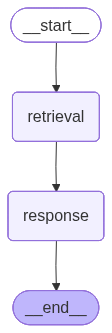

✅ Graph visualization above (if graphviz is installed)


In [8]:
# Visualize the pipeline
print("\n" + "="*60)
print("PIPELINE VISUALIZATION")
print("="*60)
print("""
    START
      ↓
┌─────────────────┐
│  retrieval      │ ← Agent 1: Extract filters & search Qdrant
└────────┬────────┘
         ↓
┌─────────────────┐
│  response       │ ← Agent 2: Format events into response
└────────┬────────┘
         ↓
       END

Nodes: 2 agents
Edges: Linear (no conditional routing)
State Flow: query → filters → retrieved_events → response
LangSmith Tracing: Enabled
""")

# Try to display the graph if graphviz is available
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
    print("✅ Graph visualization above (if graphviz is installed)")
except Exception as e:
    print(f"ℹ️  Graph visualization unavailable (install graphviz for visual graph): {type(e).__name__}")


## 6. Test the Pipeline

Test with multiple queries to verify end-to-end functionality.


In [10]:
def run_pipeline(query: str) -> str:
    """
    Run the agentic RAG pipeline end-to-end.
    """
    print(f"\n{'='*60}")
    print(f"QUERY: {query}")
    print(f"{'='*60}\n")
    
    initial_state = {
        "query": query,
        "filters": {},
        "retrieved_events": [],
        "response": ""
    }
    
    # Run the pipeline (with LangSmith tracing)
    final_state = app.invoke(initial_state)
    
    return final_state["response"]

print("✅ Pipeline runner defined!")


✅ Pipeline runner defined!


In [12]:
# Test 1: Baby-friendly query
from IPython.display import Markdown, display

query1 = "What's this Saturday that's baby-friendly?"
response1 = run_pipeline(query1)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response1))



QUERY: What's this Saturday that's baby-friendly?

🔍 Extracted filters: {'baby_friendly': True}
✅ Retrieved 10 events
✅ Response generated!

RESPONSE:



Absolutely! I’m thrilled to help you find some baby-friendly events happening this Saturday in NYC! Here are some fantastic options for you and your little one:

### 1. **30.BUBS Candy "Sweeteasy" Pop-Up**
Indulge in the Swedish tradition of "lördagsgodis" at this delightful candy pop-up! It's a sweet way to enjoy some treats together.  
**Baby-Friendly:** Yes  
[More Info Here](https://www.timeout.com/newyork/things-to-do/bubs-candy-sweeteasy-pop-up)

### 2. **15.Ascarium at the New York Aquarium**
Dive into a world of marine magic! The Ascarium features under-the-sea animals, magic shows, Halloween crafts, and a costume parade. Perfect for little explorers!  
**Baby-Friendly:** Yes  
[More Info Here](https://www.timeout.com/newyork/things-to-do/ascarium-at-the-new-york-aquarium)

### 3. **16.Bronx Zoo Harvest Glow**
Experience the Bronx Zoo like never before with its enchanting nighttime celebration! Enjoy family-friendly activities and see the zoo in a whole new light.  
**Baby-Friendly:** Yes  
[More Info Here](https://www.timeout.com/newyork/things-to-do/bronx-zoo-harvest-glow)

### 4. **64.Smorgasburg**
Head to Smorgasburg, the ultimate food bazaar! With a variety of local vendors, you can enjoy delicious bites while your baby takes in the sights and sounds.  
**Baby-Friendly:** Yes  
[More Info Here](https://www.timeout.com/newyork/restaurants/smorgasburg-guide)

These events are sure to create wonderful memories for you and your little one! Enjoy your Saturday filled with fun and adventure! 🌟

In [13]:
# Test 2: Romantic/vibe query (semantic search shines here!)
query2 = "Romantic date night near a museum"
response2 = run_pipeline(query2)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response2))



QUERY: Romantic date night near a museum

🔍 Extracted filters: {}
✅ Retrieved 10 events
✅ Response generated!

RESPONSE:



Absolutely! I’d love to help you find the perfect romantic date night near a museum in NYC. Here are some fantastic options that will surely set the mood for a lovely evening:

### 1. **"Monet and Venice" at Brooklyn Museum**
   - **Description:** Dive into the enchanting world of Venice through Claude Monet's iconic paintings. This exhibit is a rare reunion of his masterpieces that beautifully capture the essence of the floating city.
   - **Baby-Friendly:** Yes
   - **More Info:** [Brooklyn Museum - Monet and Venice](https://www.timeout.com/newyork/news/first-look-discover-the-serenity-of-venice-through-nycs-largest-monet-show-in-25-years-100825)

### 2. **MoMA Before Hours Tour**
   - **Description:** Experience the Museum of Modern Art like never before! Enjoy exclusive access to precious artworks without the crowds, allowing you to admire the brushstrokes and details up close.
   - **Baby-Friendly:** No
   - **More Info:** [MoMA Before Hours Tour](https://www.timeout.com/newyork/news/see-precious-artworks-at-moma-before-the-crowds-at-these-exclusive-new-tours-050323)

### 3. **43.Arte Museum**
   - **Description:** Immerse yourselves in a multi-sensory journey at the new Arte Museum, featuring digital art, soundscapes, and custom-crafted scents. It's a unique experience that transcends traditional art viewing!
   - **Baby-Friendly:** Yes
   - **More Info:** [Arte Museum](https://www.timeout.com/newyork/art/arte-museum)

These events offer a blend of art, romance, and a touch of magic, perfect for a memorable date night! Enjoy your evening, and don’t hesitate to reach out if you need more recommendations. Have a wonderful time! 🌟

In [14]:
# Test 3: High-energy activity
query3 = "High-energy outdoor activity with friends"
response3 = run_pipeline(query3)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response3))



QUERY: High-energy outdoor activity with friends

🔍 Extracted filters: {}
✅ Retrieved 10 events
✅ Response generated!

RESPONSE:



Hey there! 🌟 It sounds like you're looking for some high-energy outdoor activities to enjoy with your friends in NYC! I've got some fantastic options for you that are sure to get your adrenaline pumping and create some unforgettable memories. Check these out:

### 1. Laser Tag at Mini-Bowling at Area 53
Dive into a thrilling experience at Area 53, where you can enjoy laser tag, mini-bowling, and arcade games all in one place! It's a fun-filled environment perfect for a competitive day out with friends.
- **Baby-Friendly:** No
- [More Info](https://www.timeout.com/newyork/things-to-do/area-53)

### 2. Longest Table at Gotham Park
Join a community potluck under the iconic Brooklyn Bridge! Bring your favorite dish and enjoy dining al fresco with friends while soaking in the beautiful views. It's a unique way to connect with others and enjoy the outdoors.
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/news/a-crazy-long-community-potluck-table-will-be-stretching-out-underneath-the-brooklyn-bridge-next-weekand-its-free-to-join-100725)

### 3. Wild Captives Archery Studio
Channel your inner Katniss Everdeen at this empowering archery studio in Brooklyn! It's a fantastic way to bond with friends while learning a new skill in a supportive environment.
- **Baby-Friendly:** No
- [More Info](https://www.timeout.com/newyork/news/channel-your-inner-katniss-everdeen-at-the-nations-first-woman-owned-archery-range-072623)

### 4. Act & Sip NYC
If you're looking for something a bit different, try this beer-fueled acting workshop in an Off-Broadway theater! It's a fun way to unleash your creativity and enjoy a night out with friends.
- **Baby-Friendly:** No
- [More Info](https://www.timeout.com/newyork/things-to-do/act-sip-nyc)

### 5. Latin Mix Saturdays
Get ready to dance the night away at Time Out Market’s Rooftop Latin Mix Party! Enjoy reggaetón, salsa, and more with a vibrant crowd. It's the perfect way to let loose and have a blast with friends.
- **Baby-Friendly:** No
- [More Info](https://www.timeout.com/time-out-market-new-york/time-out-market/latin-mix-saturdays)

I hope one of these events sparks your interest! Have an amazing time with your friends, and enjoy all the energy NYC has to offer! 🎉

In [15]:
# Test 4: Relaxing cultural event
query4 = "Relaxing cultural event for adults"
response4 = run_pipeline(query4)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response4))



QUERY: Relaxing cultural event for adults

🔍 Extracted filters: {}
✅ Retrieved 10 events
✅ Response generated!

RESPONSE:



Absolutely! I’d love to help you find a relaxing cultural event in NYC. Here are some fantastic options that you might enjoy:

### 1. **43.Arte Museum**
Dive into a world of immersive digital art, captivating soundscapes, and custom-crafted scents at the new Arte Museum. It promises a multi-sensory journey that will transport you beyond time and space. Perfect for a serene outing!
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/art/arte-museum)

### 2. **Lincoln Center's Festival of Firsts**
Join the celebration of bold and innovative art at Lincoln Center! This free festival runs through October 23 at the David Rubenstein Atrium, showcasing exciting new performances and installations. No ticket required!
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/news/lincoln-center-just-announced-a-massive-free-culture-festival-this-month-and-it-looks-pretty-great-092925)

### 3. **Queens Night Market**
Experience the vibrant flavors of NYC at the Queens Night Market! For just $5-6, you can sample some of the best eats from local vendors. It’s a delightful way to enjoy food and culture in a relaxed atmosphere.
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/things-to-do/queens-night-market-1)

### 4. **Handmade Happy Hour**
Unleash your creativity with a pottery class at Greenwich House Pottery! This Friday night happy hour is perfect for beginners looking to get their hands dirty and unwind with some art.
- **Baby-Friendly:** No
- [More Info](https://www.timeout.com/newyork/things-to-do/handmade-happy-hour)

### 5. **Act & Sip NYC**
If you’re looking for something a bit different, try Act & Sip! This unique beer-fueled acting workshop in an Off-Broadway Theater combines creativity with a fun atmosphere. Perfect for those who want to explore their artistic side!
- **Baby-Friendly:** No
- [More Info](https://www.timeout.com/newyork/things-to-do/act-sip-nyc)

I hope one of these events catches your eye! Enjoy your cultural adventure in the city! 🌟

In [16]:
# Test 5: Kid-friendly museum
query5 = "Kid-friendly museum activity"
response5 = run_pipeline(query5)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response5))



QUERY: Kid-friendly museum activity

🔍 Extracted filters: {'baby_friendly': True}
✅ Retrieved 10 events
✅ Response generated!

RESPONSE:



Absolutely! I’m thrilled to help you find some fantastic kid-friendly museum activities in NYC! Here are some exciting options that your little ones will love:

### 1. **Ascarium at the New York Aquarium**
Dive into a marine wonderland at the New York Aquarium's Ascarium! Kids can enjoy magical shows, Halloween crafts, a scavenger hunt, a costume parade, and more! It’s a perfect blend of fun and learning about under-the-sea creatures.
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/things-to-do/ascarium-at-the-new-york-aquarium)

### 2. **Sloomoo Institute Slime Museum**
Get ready for a gooey adventure at the Sloomoo Institute! This newly renovated slime museum is a sensory playground where kids can explore colorful slime creations and enjoy interactive exhibits. It’s a delightful experience for all ages!
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/news/5-things-to-do-at-sloomoos-newly-renovated-slime-museum-in-soho-092322)

### 3. **The Big Bubble Experiment at NYSCI**
Bubbles, bubbles everywhere! The New York Hall of Science has brought back its beloved bubble exhibit, now bigger and better than ever. Kids will be mesmerized by the science of bubbles and can even participate in hands-on activities!
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/news/new-york-hall-of-science-debuts-the-new-big-bubble-experiment-111023)

### 4. **Arte Museum**
Step into a world of immersive digital art at the Arte Museum! This multi-sensory experience combines stunning visuals, soundscapes, and even custom scents, making it a captivating journey for kids and adults alike.
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/art/arte-museum)

### 5. **The Amazing Maize Maze**
Celebrate fall with a fun-filled adventure at the Queens County Farm Museum! The Amazing Maize Maze is a three-acre labyrinth that promises a day of exploration and excitement for the whole family.
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/news/the-amazing-maize-maze-is-back-in-queens-this-fall-with-a-tricky-three-acre-labyrinth-101025)

I hope you find these events as exciting as I do! Enjoy your time exploring and making wonderful memories with your kids! 🌟

## 7. Create Backend Files

Now we'll create the production-ready backend files for FastAPI.


### 7.1 Create `backend/agents.py`


In [17]:
agents_code = '''"""Agentic RAG pipeline for NYC Event Recommender.

This module implements a 2-agent system:
1. Retrieval Agent: Extracts filters and retrieves relevant events
2. Response Agent: Formats events into natural language responses
"""

import os
import json
from typing import Dict, List, Any, TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END
from backend.vector_store import VectorStore


class AgentState(TypedDict):
    """State passed between agents in the pipeline."""
    query: str
    filters: Dict[str, Any]
    retrieved_events: List[Dict]
    response: str


class EventRecommenderPipeline:
    """2-agent RAG pipeline for event recommendations."""
    
    def __init__(self, qdrant_path: str = "./local_qdrant"):
        """Initialize the pipeline with LLM and vector store."""
        self.llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        self.vector_store = VectorStore(path=qdrant_path)
        self.app = self._build_graph()
    
    def retrieval_agent(self, state: AgentState) -> AgentState:
        """Agent 1: Extract filters and retrieve relevant events."""
        query = state["query"]
        
        # Extract filters using LLM
        filter_prompt = f"""Given this user query about NYC events, extract any explicit filters.

Query: "{query}"

Return JSON with these optional filters:
- baby_friendly: true/false (if query mentions babies, infants, toddlers, strollers, kids, family-friendly)
- price: "free" (only if query explicitly mentions free)

If a filter is not mentioned, omit it from the JSON.

Examples:
- "baby-friendly museum" → {{"baby_friendly": true}}
- "free outdoor event" → {{"price": "free"}}
- "romantic date night" → {{}}
- "stroller-accessible park" → {{"baby_friendly": true}}

Return ONLY valid JSON, no explanations."""

        try:
            filter_response = self.llm.invoke([
                SystemMessage(content="You extract metadata filters from user queries. Always return valid JSON."),
                HumanMessage(content=filter_prompt)
            ])
            filters = json.loads(filter_response.content)
        except Exception as e:
            print(f"Filter extraction failed: {e}")
            filters = {}
        
        # Search vector store
        search_results = self.vector_store.search_events(
            query=query,
            top_k=10,
            filters=filters if filters else None
        )
        
        state["filters"] = filters
        state["retrieved_events"] = search_results
        return state
    
    def response_agent(self, state: AgentState) -> AgentState:
        """Agent 2: Format retrieved events into natural language response."""
        query = state["query"]
        events = state["retrieved_events"]
        
        if not events:
            state["response"] = "I couldn't find any events matching your criteria. Try broadening your search!"
            return state
        
        # Prepare event context
        event_context = ""
        for i, result in enumerate(events[:5], 1):
            event = result["event"]
            score = result["score"]
            event_context += f"""
Event {i}:
- Title: {event['title']}
- Description: {event['description'][:200]}...
- Baby-Friendly: {'Yes' if event['baby_friendly'] else 'No'}
- URL: {event['url']}
- Relevance Score: {score:.2f}

"""
        
        # Generate response
        response_prompt = f"""You are a helpful NYC event recommender assistant.

User Query: "{query}"

Here are the top events I found:
{event_context}

Task: Write a friendly, conversational response recommending these events. Include:
1. A brief intro acknowledging their query
2. Top 3-5 events with titles, brief descriptions, and key details
3. Mention if events are baby-friendly when relevant
4. Include URLs for more info
5. End with an encouraging note

Format in markdown. Be enthusiastic but concise!"""

        response_message = self.llm.invoke([
            SystemMessage(content="You are a friendly NYC event recommendation assistant. Be helpful and enthusiastic!"),
            HumanMessage(content=response_prompt)
        ])
        
        state["response"] = response_message.content
        return state
    
    def _build_graph(self) -> StateGraph:
        """Build the LangGraph pipeline."""
        workflow = StateGraph(AgentState)
        
        # Add nodes
        workflow.add_node("retrieval", self.retrieval_agent)
        workflow.add_node("response", self.response_agent)
        
        # Define edges
        workflow.set_entry_point("retrieval")
        workflow.add_edge("retrieval", "response")
        workflow.add_edge("response", END)
        
        return workflow.compile()
    
    def run(self, query: str) -> Dict[str, Any]:
        """Run the pipeline end-to-end."""
        initial_state = {
            "query": query,
            "filters": {},
            "retrieved_events": [],
            "response": ""
        }
        
        final_state = self.app.invoke(initial_state)
        
        return {
            "query": query,
            "filters": final_state["filters"],
            "events": final_state["retrieved_events"],
            "response": final_state["response"]
        }
'''

# Write to file
backend_dir = Path("../backend")
agents_path = backend_dir / "agents.py"
agents_path.write_text(agents_code)

print(f"✅ Created {agents_path}")
print("\nModule includes:")
print("  - AgentState (TypedDict)")
print("  - EventRecommenderPipeline class")
print("  - retrieval_agent()")
print("  - response_agent()")
print("  - run() method for end-to-end execution")


✅ Created ../backend/agents.py

Module includes:
  - AgentState (TypedDict)
  - EventRecommenderPipeline class
  - retrieval_agent()
  - response_agent()
  - run() method for end-to-end execution


### 7.2 Create `backend/main.py` (FastAPI)


In [18]:
fastapi_code = '''"""FastAPI backend for NYC Event Recommender.

This module provides REST API endpoints for event recommendations
using the agentic RAG pipeline.
"""

import os
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv
from backend.agents import EventRecommenderPipeline

# Load environment variables
load_dotenv()

# Configure LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "nyc-event-recommender"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

# Initialize FastAPI app
app = FastAPI(
    title="NYC Event Recommender API",
    description="AI-powered event recommendation system for NYC",
    version="1.0.0"
)

# Add CORS middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Initialize the pipeline
pipeline = EventRecommenderPipeline(qdrant_path="./local_qdrant")


class QueryRequest(BaseModel):
    """Request model for event recommendations."""
    query: str = Field(..., description="User query for event recommendations")
    top_k: Optional[int] = Field(5, description="Number of events to return", ge=1, le=20)


class QueryResponse(BaseModel):
    """Response model for event recommendations."""
    query: str
    filters: dict
    response: str
    num_events: int


@app.get("/")
def read_root():
    """Health check endpoint."""
    return {
        "message": "NYC Event Recommender API",
        "status": "online",
        "version": "1.0.0"
    }


@app.post("/recommend", response_model=QueryResponse)
def recommend_events(request: QueryRequest):
    """
    Get event recommendations based on user query.
    
    Args:
        request: QueryRequest with user query and optional top_k
    
    Returns:
        QueryResponse with recommendations and metadata
    """
    try:
        # Run the pipeline
        result = pipeline.run(request.query)
        
        return QueryResponse(
            query=result["query"],
            filters=result["filters"],
            response=result["response"],
            num_events=len(result["events"])
        )
    
    except Exception as e:
        raise HTTPException(
            status_code=500,
            detail=f"Error processing query: {str(e)}"
        )


@app.get("/health")
def health_check():
    """Detailed health check with component status."""
    return {
        "status": "healthy",
        "components": {
            "vector_store": "online",
            "llm": "online",
            "langgraph": "online"
        }
    }


if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

# Write to file
main_path = backend_dir / "main.py"
main_path.write_text(fastapi_code)

print(f"✅ Created {main_path}")
print("\nFastAPI endpoints:")
print("  - GET  /             → Health check")
print("  - POST /recommend    → Get event recommendations")
print("  - GET  /health       → Detailed health status")
print("\nTo start the server:")
print("  cd /path/to/project")
print("  uvicorn backend.main:app --reload")


✅ Created ../backend/main.py

FastAPI endpoints:
  - GET  /             → Health check
  - POST /recommend    → Get event recommendations
  - GET  /health       → Detailed health status

To start the server:
  cd /path/to/project
  uvicorn backend.main:app --reload
